In [1]:
from barf.biased_rf import BiasedRFClassifier, RandomForestClassifier
from barf.base import train_test_split, classifier_report, k_fold_validation, roc_curve, prc_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv('data/diabetes.csv')

## 1. data inspection

In [3]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
label, count = np.unique(data['Outcome'], return_counts=True)
print(dict(zip(label, count)))

{0: 500, 1: 268}


### 1.1 unbalanced labels
The set containing truth label ``1`` is about half the size of the set containing label ``0``. The data set is unbalanced. However, the degree of unbalance (ratio between the size of the two labels) is not too far from 1. We will test both the biased random forest and a valina random forest approach.

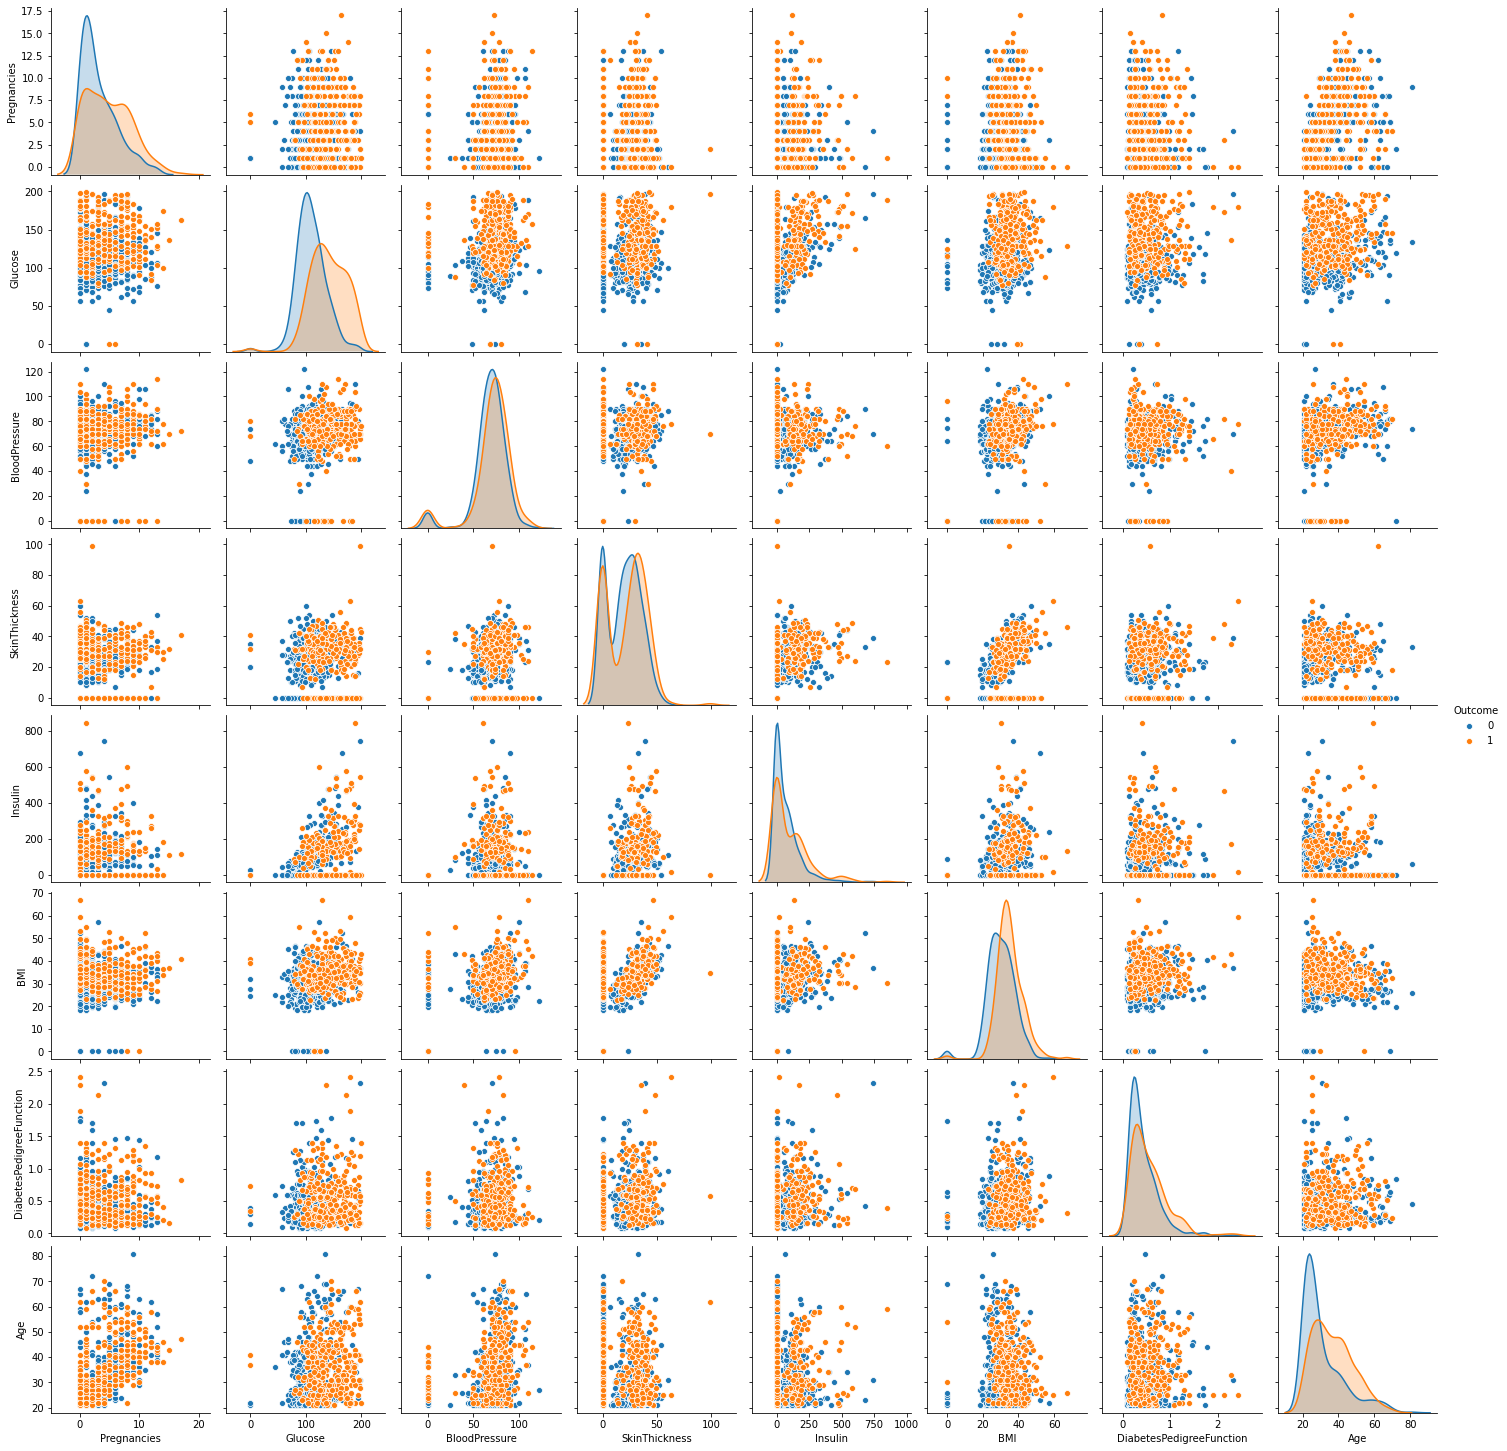

In [5]:
sns.pairplot(data, hue='Outcome')

### 1.2 Null values
The inspection show no null values, however, there are values that doesn't make physical/medical sense. Most of those abnormal values represents a small subset of the overall data.

- `Glucose` == 0
- `BloodPressure` == 0
- `SkinThickness` == 0: here we have a significant amount of rows with 0 skin thickness mesaurements
- `BMI` == 0

Below we replace those 0 values with nulls to flag them in the dataset.

In [6]:
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']:
    data.loc[:, col] = data[col].replace({0: np.nan})

In [7]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,768.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,79.799479,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,115.244002,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,0.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,30.500000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<AxesSubplot:>

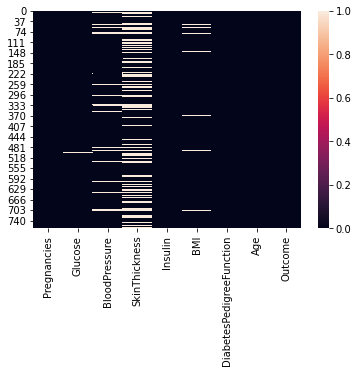

In [8]:
sns.heatmap(data.isnull())

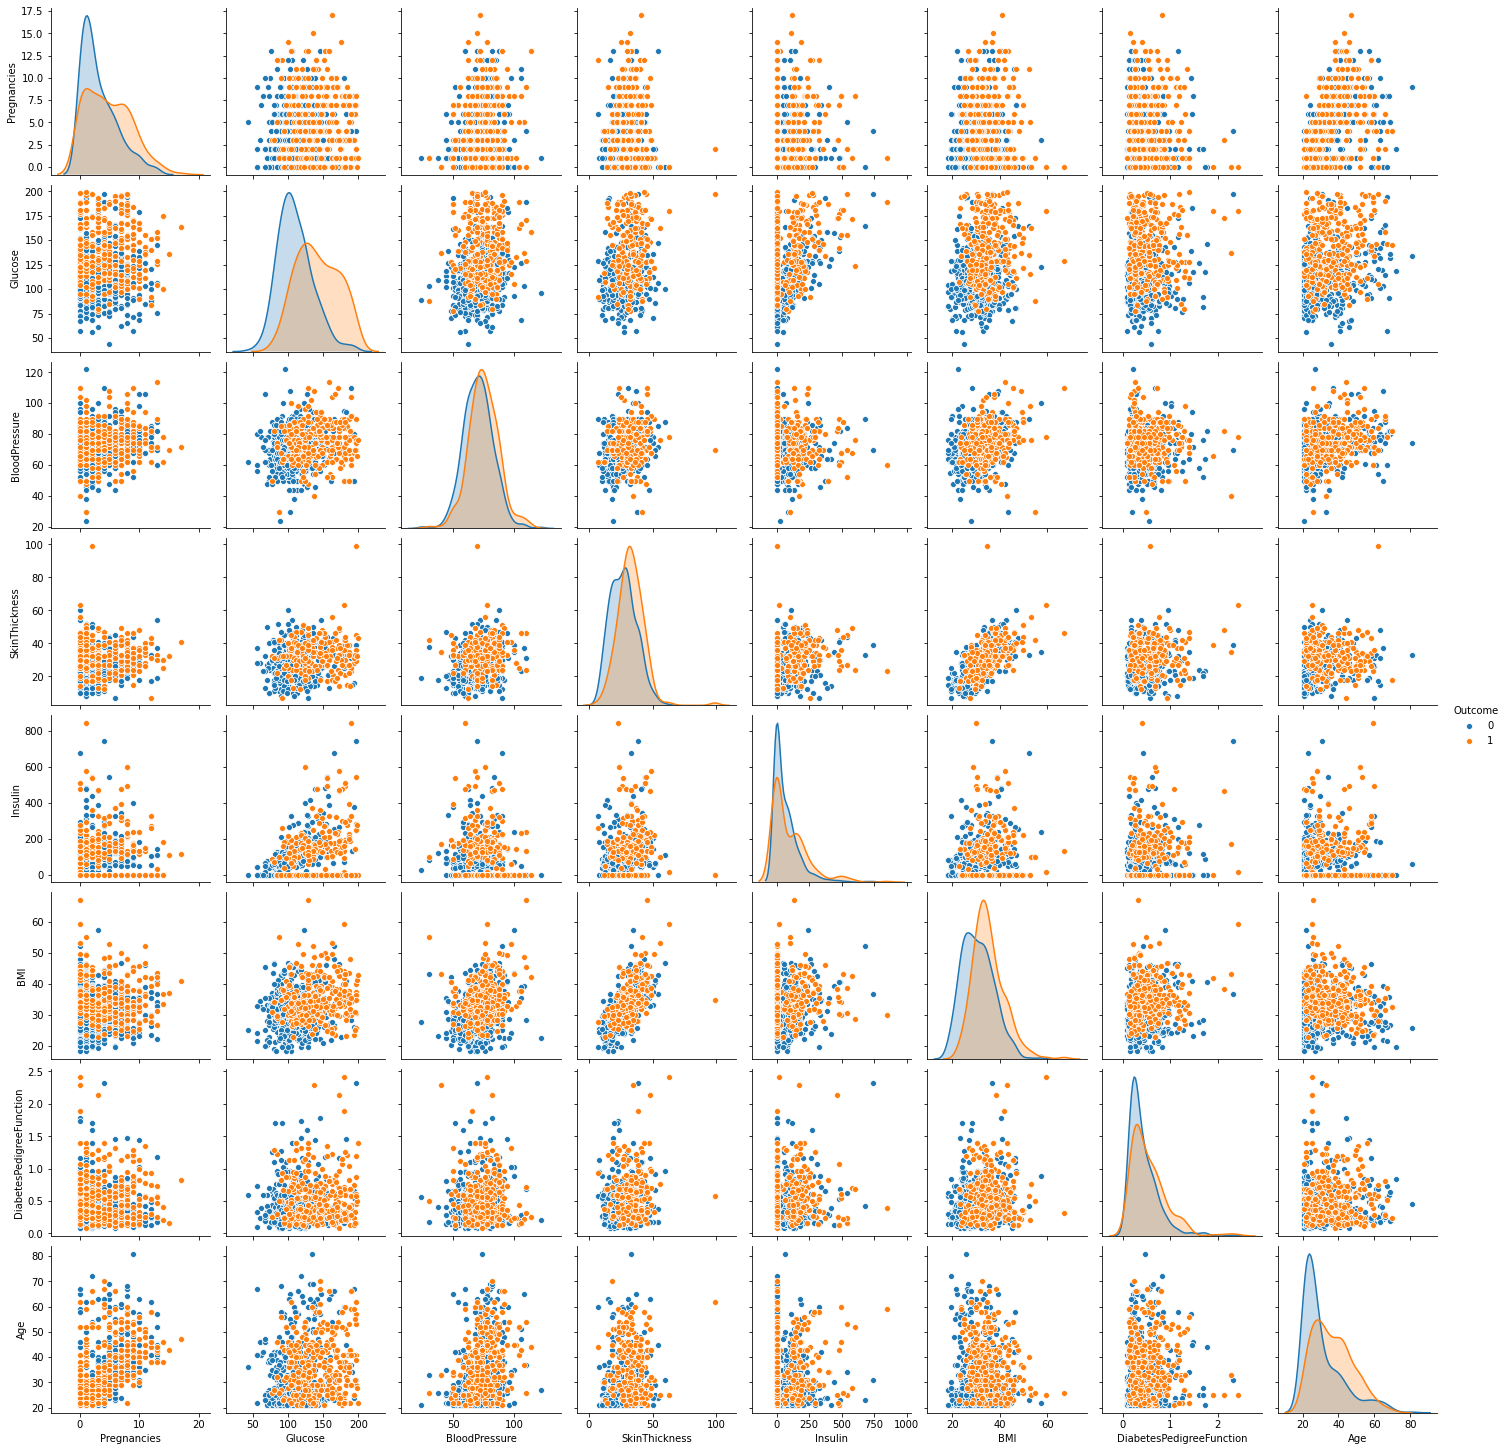

In [9]:
sns.pairplot(data, hue='Outcome')

#### Skin Thickness

The new pairplot shows that whereever thee is `SkinThickness` entry they seem to corrleate to other features, especially `BMI` closely. This observation suggests that information contained in `SkinThickness` could be already in other features. Therefore, we first try to build a model without `SkinThickness` and try to impute it later with other features to build another model with the imputed `SkinThickness`. We can also use an ensemble approach where we build a model with skin thickness after dropping nulls and a model without skin thickness then use both models to make predictions depending on if skin thickness is available.

#### BMI, Glucose, and Blood Pressure

There are not too many missing values from those features so we first build a model without the row containing any null values. 

In [56]:
data_nona = data.dropna(how='any', subset=[col for col in data if col!='SkinThickness']).copy().reset_index(drop=True)
data_nona.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,724.000000,724.000000,724.000000,532.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,3.866022,121.882597,72.400552,29.182331,84.494475,32.467127,0.474765,33.350829,0.343923
std,3.362803,30.750030,12.379870,10.523878,117.016513,6.888941,0.332315,11.765393,0.475344
min,0.000000,44.000000,24.000000,7.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,22.000000,0.000000,27.500000,0.245000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,48.000000,32.400000,0.379000,29.000000,0.000000
75%,6.000000,142.000000,80.000000,36.000000,130.500000,36.600000,0.627500,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [57]:
trainx_sk, testx_sk, trainy, testy = train_test_split(data_nona.iloc[:, :-1], data_nona[['Outcome']], random_seed=42)
trainx = trainx_sk.drop(columns=['SkinThickness'])
trainx.describe()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,3.826430,121.934911,72.331361,84.114398,32.207692,0.454586,33.333333
std,3.306696,30.447222,12.175620,120.722048,6.937334,0.303217,12.141676
min,0.000000,44.000000,30.000000,0.000000,18.200000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,0.000000,27.300000,0.244000,24.000000
50%,3.000000,117.000000,72.000000,44.000000,32.000000,0.370000,29.000000
75%,6.000000,140.000000,80.000000,130.000000,36.500000,0.599000,41.000000
max,13.000000,199.000000,114.000000,846.000000,67.100000,2.329000,81.000000


In [58]:
testx = testx_sk.drop(columns=['SkinThickness'])
testx.describe()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,3.958525,121.760369,72.562212,85.382488,33.073272,0.521912,33.391705
std,3.496444,31.517157,12.871770,108.126881,6.751497,0.388685,10.862291
min,0.000000,57.000000,24.000000,0.000000,19.500000,0.084000,21.000000
25%,1.000000,97.000000,64.000000,0.000000,27.800000,0.251000,25.000000
50%,3.000000,117.000000,74.000000,61.000000,32.900000,0.402000,30.000000
75%,6.000000,144.000000,80.000000,135.000000,37.000000,0.686000,41.000000
max,17.000000,197.000000,122.000000,579.000000,59.400000,2.420000,68.000000


## 2. Modeling

The label `1` has less members than label `0` but the ratio between the number of members in those two labels are not significantly away from 1 so we will build two models using Random Forest and Biased Random Forest respectively and compare the performance.

We split the data into a train and test set. We further use 10-fold cross-validation approach on the training set and compare different models with the validation scores. Once we choose a final model with the best validation scores we retrain the model with the full train set, then evaluate its performance on the test set to get the final model's expected performance metrics.

### 2.1 biased rf without skin thickness

In [34]:
brf = BiasedRFClassifier(max_depth=100, sub_samples=0.5, max_features=3)
callbacks = {
    'roc': ('probs', roc_curve), 
    'prc': ('probs', prc_curve), 
    'confusion': ('labels', classifier_report)
}

results = k_fold_validation(
    brf, trainx, trainy, folds=10, 
    callbacks=callbacks, 
    random_seed=42
)

/mnt/c/Users/theya/develop/ML_Technical/barf/base.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  splits = np.array(k_fold_split(data, folds, random_seed))


In [26]:
def summary_plots(results, prefix='model', save_fig=False, label_size=14):
    fig, axes = plt.subplots(figsize=(20, 10), ncols=2)
    axes[0].plot([0, 1], [0, 1], '--r', alpha=0.5, label='random guess line')
    for key, val in results.items():
        axes[0].plot(val['roc'][0], val['roc'][1], '-', label=key)
    axes[0].set_xlabel('Flase Positive Rate', fontsize=label_size)
    axes[0].set_ylabel('False Negative Rate', fontsize=label_size)
    axes[0].grid()
    axes[0].legend()
    
    axes[1].plot([0, 1], [count[1]/sum(count), count[1]/sum(count)], '--r', alpha=0.5, label='random guess line')
    for key, val in results.items():
        axes[1].plot(val['prc'][0], val['prc'][1], '-', label=key)
    axes[1].set_xlabel('Recall', fontsize=label_size)
    axes[1].set_ylabel('Precision', fontsize=label_size)
    axes[1].grid()
    axes[1].legend()
    
    if save_fig:
        plt.savefig(os.path.join('tmp', prefix, 'roc_and_prc.png'))

In [16]:
def summarize(results):
    aurocs=list()
    auprcs=list()
    for key, result in results.items():
        print('---------------------------------------------------')
        print(key)
        print(', '.join([key+'='+str(int(val)) for key, val in result['confusion'].items()]))
        auroc = np.trapz(result['roc'][1], result['roc'][0])
        auprc = np.trapz(result['prc'][1], result['prc'][0])
        print(f"auROC: {auroc}")
        print(f"auPRC: {auprc}")
        aurocs.append(auroc)
        auprcs.append(auprc)
    return aurocs, auprcs

#### 2.1.1 ROC and PRC plots

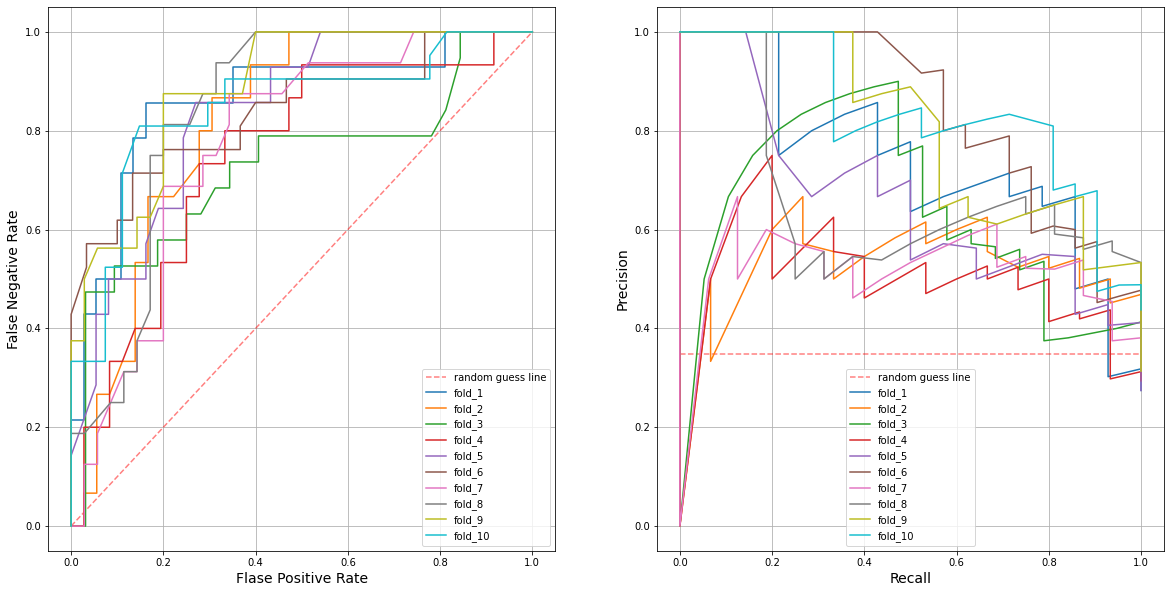

In [35]:
summary_plots(results)

#### 2.1.2 Confusion Matrix contents and AUROC, AUPRC for each fold

In [36]:
aurocs, auprcs = summarize(results)

---------------------------------------------------
fold_1
true_positives=210, true_negatives=1332, false_positives=555, false_negatives=504
auROC: 0.862934362934363
auPRC: 0.7405329258200813
---------------------------------------------------
fold_2
true_positives=210, true_negatives=1332, false_positives=504, false_negatives=555
auROC: 0.8175925925925925
auPRC: 0.521452857838143
---------------------------------------------------
fold_3
true_positives=190, true_negatives=1312, false_positives=320, false_negatives=779
auROC: 0.7286184210526316
auPRC: 0.6219933291577666
---------------------------------------------------
fold_4
true_positives=270, true_negatives=1188, false_positives=648, false_negatives=495
auROC: 0.7490740740740741
auPRC: 0.49124716860487955
---------------------------------------------------
fold_5
true_positives=140, true_negatives=1517, false_positives=370, false_negatives=574
auROC: 0.8368725868725869
auPRC: 0.6611680947095501
------------------------------------

### 2.2 random forest

In [37]:
rf = RandomForestClassifier(max_depth=100, sub_samples=0.5, max_features=3)

rf_results = k_fold_validation(rf, trainx, trainy, folds=10, callbacks=callbacks, random_seed=42)

/mnt/c/Users/theya/develop/ML_Technical/barf/base.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  splits = np.array(k_fold_split(data, folds, random_seed))


#### 2.2.1 ROC and PRC plots

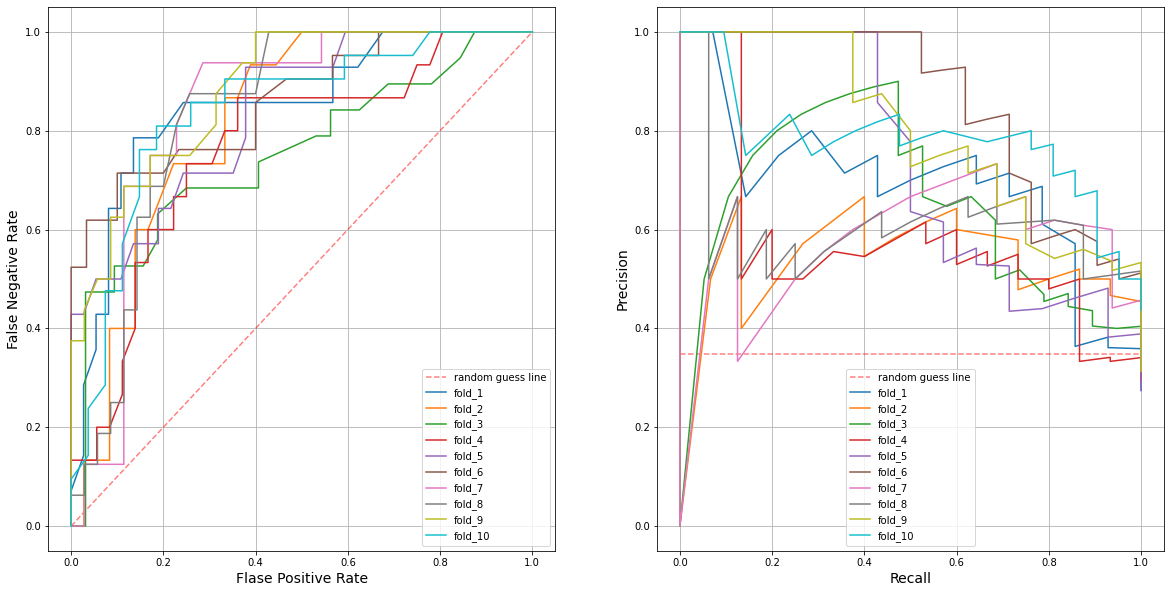

In [38]:
summary_plots(rf_results)

#### 2.2.2 Confusion Matrix contents and AUROC, AUPRC for each fold

In [39]:
rf_aurocs, rf_auprcs = summarize(rf_results)

---------------------------------------------------
fold_1
true_positives=224, true_negatives=1295, false_positives=592, false_negatives=490
auROC: 0.8513513513513513
auPRC: 0.6890175504933908
---------------------------------------------------
fold_2
true_positives=180, true_negatives=1404, false_positives=432, false_negatives=585
auROC: 0.8194444444444445
auPRC: 0.5316276533027106
---------------------------------------------------
fold_3
true_positives=209, true_negatives=1280, false_positives=352, false_negatives=760
auROC: 0.7516447368421052
auPRC: 0.6340720883823693
---------------------------------------------------
fold_4
true_positives=255, true_negatives=1224, false_positives=612, false_negatives=510
auROC: 0.7657407407407408
auPRC: 0.5746664943872525
---------------------------------------------------
fold_5
true_positives=140, true_negatives=1517, false_positives=370, false_negatives=574
auROC: 0.8368725868725869
auPRC: 0.7331718791964715
-----------------------------------

### 2.3 imputing skin thickness with BMI

The plot below suggests that skin thickness is closely related to BMI so we will use BMI to impute the missing skin thickness values then add skin thickness into the model.

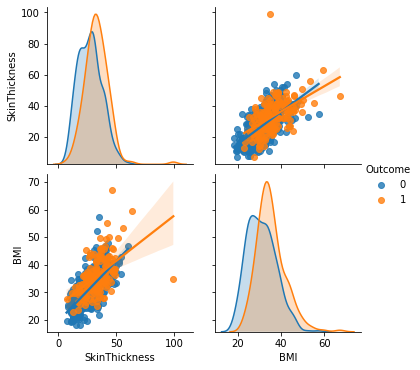

In [59]:
sns.pairplot(data_nona[['SkinThickness', 'BMI', 'Outcome']], hue='Outcome', kind='reg')

Building imputing model using simple linear regression and the __training__ data set.

In [60]:
fit_data = trainx_sk[['SkinThickness', 'BMI']].dropna(how='any')

In [61]:
a1, a0 = np.polyfit(fit_data['BMI'].values, fit_data['SkinThickness'].values, 1)

In [43]:
data_withsk = data.copy()

In [66]:
idx_skin_missing = trainx_sk['SkinThickness'].isnull()
trainx_sk.loc[idx_skin_missing, 'SkinThickness'] = a1 * trainx_sk.loc[idx_skin_missing, 'BMI'] + a0

idx_skin_missing = testx_sk['SkinThickness'].isnull()
testx_sk.loc[idx_skin_missing, 'SkinThickness'] = a1 * testx_sk.loc[idx_skin_missing, 'BMI'] + a0

In [67]:
trainx_sk.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,3.826430,121.934911,72.331361,28.555145,84.114398,32.207692,0.454586,33.333333
std,3.306696,30.447222,12.175620,9.787761,120.722048,6.937334,0.303217,12.141676
min,0.000000,44.000000,30.000000,7.000000,0.000000,18.200000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,21.224362,0.000000,27.300000,0.244000,24.000000
50%,3.000000,117.000000,72.000000,28.000000,44.000000,32.000000,0.370000,29.000000
75%,6.000000,140.000000,80.000000,35.000000,130.000000,36.500000,0.599000,41.000000
max,13.000000,199.000000,114.000000,99.000000,846.000000,67.100000,2.329000,81.000000


### 2.4 biased rf with skinthickness feature

In [68]:
brf = BiasedRFClassifier(max_depth=100, sub_samples=0.5, max_features=3)
callbacks = {
    'roc': ('probs', roc_curve), 
    'prc': ('probs', prc_curve), 
    'confusion': ('labels', classifier_report)
}

sk_results = k_fold_validation(
    brf, trainx_sk, trainy, folds=10, 
    callbacks=callbacks, 
    random_seed=42
)

/mnt/c/Users/theya/develop/ML_Technical/barf/base.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  splits = np.array(k_fold_split(data, folds, random_seed))


#### 2.4.1 ROC and PRC plots

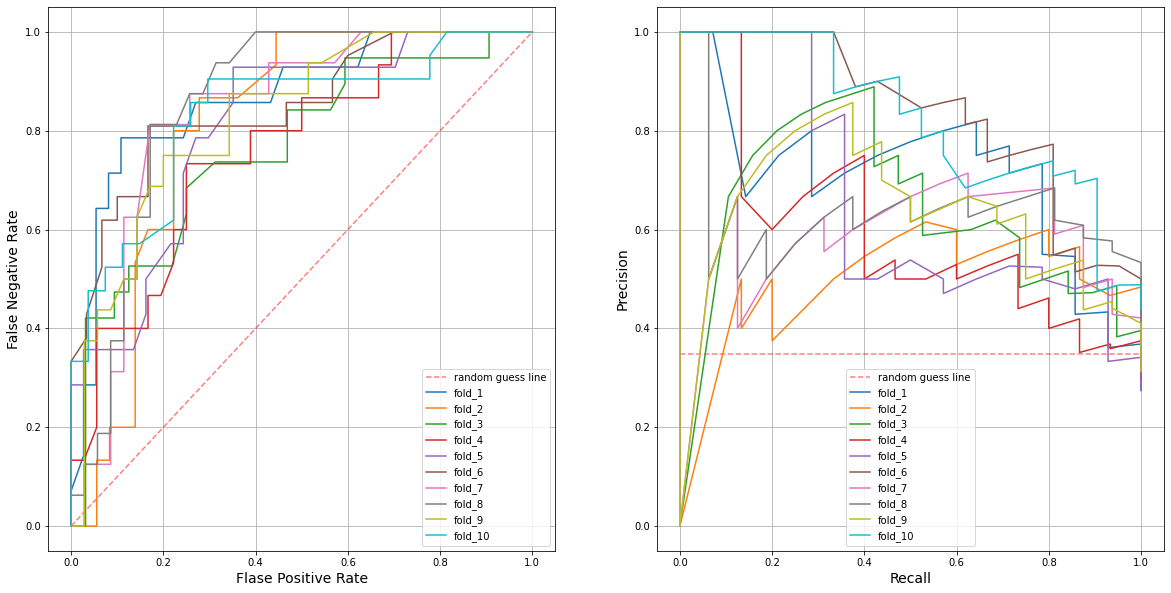

In [69]:
summary_plots(sk_results)

#### 2.4.2 Confusion Matrix contents and AUROC, AUPRC for each fold

In [70]:
sk_aurocs, sk_auprcs = summarize(sk_results)

---------------------------------------------------
fold_1
true_positives=196, true_negatives=1369, false_positives=518, false_negatives=518
auROC: 0.8667953667953667
auPRC: 0.7091446460807364
---------------------------------------------------
fold_2
true_positives=150, true_negatives=1476, false_positives=360, false_negatives=615
auROC: 0.8111111111111111
auPRC: 0.48882129462794166
---------------------------------------------------
fold_3
true_positives=266, true_negatives=1184, false_positives=448, false_negatives=703
auROC: 0.7639802631578945
auPRC: 0.6177827589016077
---------------------------------------------------
fold_4
true_positives=270, true_negatives=1188, false_positives=648, false_negatives=495
auROC: 0.762962962962963
auPRC: 0.5907905457963882
---------------------------------------------------
fold_5
true_positives=126, true_negatives=1554, false_positives=333, false_negatives=588
auROC: 0.80984555984556
auPRC: 0.656860089152675
--------------------------------------

### 2.5 model comparison

Here we use AUROC and AUPRC on the validation sets to compare the models.

In [71]:
rocs = {
    'Biased RF': aurocs,
    'RF': rf_aurocs,
    'BRF with Skin': sk_aurocs,
}
prcs = {
    'Biased RF': auprcs,
    'RF': rf_auprcs,
    'BRF with Skin': sk_auprcs,
}

In [80]:
metrics = list()
for key in rocs.keys():
    metric = pd.DataFrame(columns=['metric', 'metric type', 'folds', 'model'])
    metric['metric'] = rocs[key] + prcs[key]
    metric['metric type'] = ['AUROC'] * len(rocs[key]) + ['AUPRC'] * len(prcs[key])
    metric['folds'] = list(results.keys()) * 2
    metric['model'] = key
    metrics.append(metric)

In [81]:
metrics = pd.concat(metrics, ignore_index=True, axis=0)

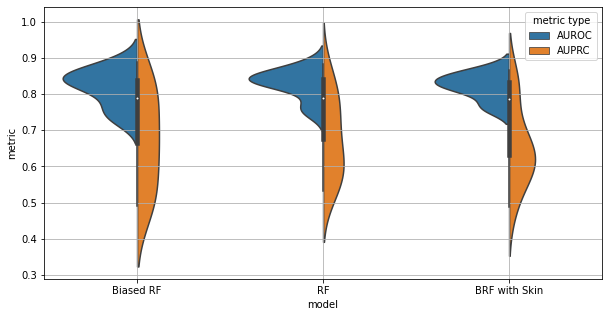

In [87]:
plt.figure(figsize=(10,5))
sns.violinplot(metrics['model'], metrics['metric'], hue=metrics['metric type'], split=True)
plt.grid()

In [89]:
metrics.groupby(['model', 'metric type']).mean()['metric']

model          metric type
BRF with Skin  AUPRC          0.654741
               AUROC          0.821678
Biased RF      AUPRC          0.668809
               AUROC          0.818857
RF             AUPRC          0.677418
               AUROC          0.828568
Name: metric, dtype: float64

In [90]:
metrics.groupby(['model', 'metric type']).std()['metric']

model          metric type
BRF with Skin  AUPRC          0.107515
               AUROC          0.035681
Biased RF      AUPRC          0.132860
               AUROC          0.051424
RF             AUPRC          0.110909
               AUROC          0.040581
Name: metric, dtype: float64

The comparison above shows that there is a slight lead for Biased RF in both AUROC and AUPRC distributions (towards the higher values). Specifically the Biased RF model provides a smaller standard deviation in the scores. Both RF and Biased RF with skin thickness have slightly higher average AUPRC but also has peaks in the lower end and has higher standard deviations, i.e., those models tend to overfit. Therefore we choose __Biased RF without skin thickness__ as the final model.

## 3. Final model and test performance

In [92]:
# fit with full training set

final_model = brf
final_model.fit(trainx, trainy)

In [94]:
# evalute over test set

pred_test = final_model.predict(testx, return_prob=False)
pred_prob = final_model.predict(testx, return_prob=True)

In [100]:
confusion = classifier_report(testy.values.ravel(), pred_test)
roc_test = roc_curve(testy.values.ravel(), pred_prob)
prc_test = prc_curve(testy.values.ravel(), pred_prob)

test_results = {'test':{
    'confusion': confusion,
    'roc': roc_test,
    'prc': prc_test
}}

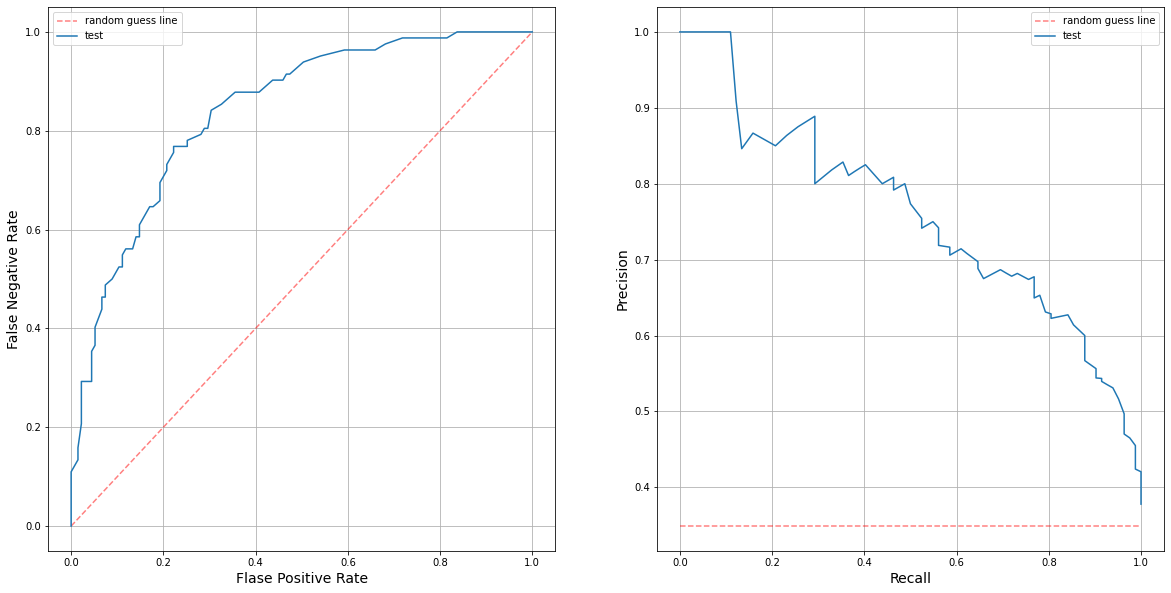

In [101]:
summary_plots(test_results)

In [102]:
summarize(test_results)

---------------------------------------------------
test
true_positives=46, true_negatives=117, false_positives=18, false_negatives=36
auROC: 0.8401084010840109
auPRC: 0.7577788883835481


([0.8401084010840109], [0.7577788883835481])